2-network-of-music-pref-solved.ipynb

2023-12-29, A. Lundervold

# 1. Practical Session: Networks of music preferences (solved)

#### Using the [Last.fm](http://millionsongdataset.com/) (millionsong) dataset

For this activity, we will create graphs using [NetworkX](https://networkx.org/) and traditional libraries for scientific computing such as [Pandas](https://pandas.pydata.org/) and [NumPy](https://numpy.org/) (data transformation and processing) plus [Matplotlib](https://matplotlib.org/) (data visualization).


## 1.1. About the dataset


We will use a reduced version of the LastFM dataset publicly available from works `[1-4]`. This dataset contains the recordings of 1000 users from Feb. 2005 until Jun. 2009. This dataset contains the following columns:

+ `userid`: User ID (anonymized)
+ `timestamp`: Timestamp of the record. The format is `YYYY-MM-DD` followed by `hh:mm:ss`. Example: `2009-04-08T01:57:47Z`.
+ `musicbrainz-artist-id`: Artists ID.
+ `artist-name`: Artist name.
+ `musicbarinz-track-id` Track ID.
+ `track-name` Track name.

For this activity, we will use the `userid`, `timestamp`, `artist-id`, and `artist-name`.

### Check your platform

In [6]:
import platform
import os
from os.path import expanduser
home = expanduser("~")

if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/My_project'
    TREE = '/usr/local/bin/tree -L 1'          # MacOS (brew install tree)
    MacOS = True
    Linux = False
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/My_project'
    TREE = '/usr/bin/tree -L 4'
    Linux = True
    MacOS = False
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')
    MacOS = False
    Linux = False

OK, you are running on MacOS (Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64)


### Check if Colab

In [7]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


## 1.2. Objectives and structure of practical session 

### 1.2.1. Objectives

1. Getting to know how to create, visualize, and analyse networks using NetworkX.
2. Apply widely used topology and centrality metrics.
3. Define networks across time for longitudinal analyses. 

### 1.2.2. Structure

**Part I : Data Exploration.**

Explore, clean, transform, and visualize data for  further analyses.



**Part II : Analyses of network of artists.**

Create, visualize, and analyze a binary Graph $G(V,E)$ such that $V$ correspond to a set of artists found in this dataset (i.e., vertices/nodes). Two artists $v_i$ and $v_j$ are connected by an edge $e_{ij}=(n_i, n_j) \in E$ if a user listen to both of them in a given time $t \in T$.

**Part III : Analyses of evolving networks based on user's preferences.**

Create, visualize, and analyze *weighted graphs* $G_t(V_t, E_t, W_t)$ for every month $t \in T$ in our dataset. The set of nodes $V_t$ corresponds to a set of artists with records at month $t$. Two artists $v_{t, i}$ and $v_{t, j}$ are connected by an edge $e_{t,ij}=(n_{t,i}, n_{t,j}) \in E$ if a user listen to both of them in a given month $t$. Such edges contains a weight $w_{t,ij} \in W_t$ corresponds to the amount of users that connect both artists $v_{t,i}$ and $v_{t,j}$.

Answer to the following questions:
+ Is the network's topology stable?
+ For this group of users, which is the most central artist? Is this most central artist the same if we use other centrality measures?
+ Is this centrality measures stable across time?

## 1.3. Playground

### 1.3.1. Part 1: Data Exploration

**Required libs**

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

    
**Reading dataset and data exploration**

```bash
--2023-12-29 13:18:31--  https://raw.githubusercontent.com/bsotomayorg/UACh-MIN-Graph_NLP/main/dataset/DS_userid-playlist-record.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25480728 (24M) [text/plain]
Saving to: ‘DS_userid-playlist-record.tsv.1’

DS_userid-playlist- 100%[===================>]  24,30M  16,5MB/s    in 1,5s    

2023-12-29 13:18:33 (16,5 MB/s) - ‘DS_userid-playlist-record.tsv.1’ saved [25480728/25480728]
```



In [10]:
if is_colab:
    ! wget https://raw.githubusercontent.com/bsotomayorg/UACh-MIN-Graph_NLP/main/dataset/DS_userid-playlist-record.tsv
    df_timestamp = pd.read_csv("DS_userid-playlist-record.tsv", sep='\t')
else:
    df_timestamp = pd.read_csv("../data/DS_userid-playlist-record.tsv", sep='\t')

In [11]:
df_timestamp

userid             timestamp  \
0       user_000001  2009-05-04T13:54:10Z   
1       user_000001  2009-05-01T08:24:50Z   
2       user_000001  2009-04-29T13:00:55Z   
3       user_000001  2009-04-26T14:56:08Z   
4       user_000001  2009-04-24T09:58:21Z   
...             ...                   ...   
191504  user_001000  2008-02-08T07:20:43Z   
191505  user_001000  2008-02-07T02:44:35Z   
191506  user_001000  2008-02-03T19:40:37Z   
191507  user_001000  2008-01-31T21:50:28Z   
191508  user_001000  2008-01-28T05:35:44Z   

                       musicbrainz-artist-id               artist-name  \
0       a7f7df4a-77d8-4f12-8acd-5c60c93f4de8                      坂本龍一   
1       a3934f47-c4cc-4e73-8b37-ce41775797d4                 Lisa Shaw   
2       495fe320-091e-43eb-9321-54a20e7c3f98       Sneaky Sound System   
3       495fe320-091e-43eb-9321-54a20e7c3f98       Sneaky Sound System   
4                                        NaN           Designed People   
...                                      ...                       ...   
191504  b7ddce8b-9e5c-46bd-9d33-41b134ce1a7f               Wolf Parade   
191505  f96627af-7aac-4e16-9245-c5661eb47199                     Muchy   
191506  e549424e-8a71-4257-acf7-18e798127cae               Katrah-Quey   
191507  a74b1b7f-71a5-4011-9441-d0b5e4122711                 Radiohead   
191508  4b2d6a23-034d-4a29-9bb9-d2462796da4e  Clap Your Hands Say Yeah   

                        musicbrainz-track-id  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3       a15efe90-1a35-4633-8888-ab4bf879527a   
4                                        NaN   
...                                      ...   
191504  27dba9c5-27de-4c07-a7bd-f279cacc34d5   
191505  30bc57a9-5646-49dd-8870-4cdca33a21f3   
191506  1d55d748-0867-4c7f-b9ec-39fbb527af86   
191507  8618e305-4289-4574-8acc-d5d8ec6b7411   
191508  30c58760-937e-40dc-8a17-78be5d657b08   

                               track-name  
0       Composition 0919 (Live_2009_4_15)  
1           Inside My Love (Extended Mix)  
2        Pictures [Radio Edit]/Radio Edit  
3                             Kansas City  
4                          Radio 808 Mars  
...                                   ...  
191504           I'Ll Believe In Anything  
191505                        Terroromans  
191506           Double Ingrown Nail June  
191507                     House Of Cards  
191508                 Details Of The War  

[191509 rows x 6 columns]

In [ ]:
# Delete the file if it exists

if os.path.exists("DS_userid-playlist-record.tsv"):
    os.remove("DS_userid-playlist-record.tsv")

**Data cleaning**

Delete from the dataset such rows that contain `NaN`s.

In [12]:
df_timestamp = df_timestamp.dropna()

Show the amount of unique users

In [8]:
print("# users", np.unique(df_timestamp['userid']).shape[0])

# users 976


Show the amount of unique artist names in the dataset

In [9]:
print("# artists", np.unique(df_timestamp['artist-name']).shape[0])

# artists 20279


Show the amount of records (i.e., rows) per year and month (`YYYY-MM`) format. Use matlpotlib to create whether a histogram or scatter plot (i.e., x-axis contains the year-month and y-axis the count of records/rows.

In [10]:
l_year_month = np.array([ item[:7] for item in df_timestamp['timestamp'].to_numpy()])

(-0.5, 52.5)

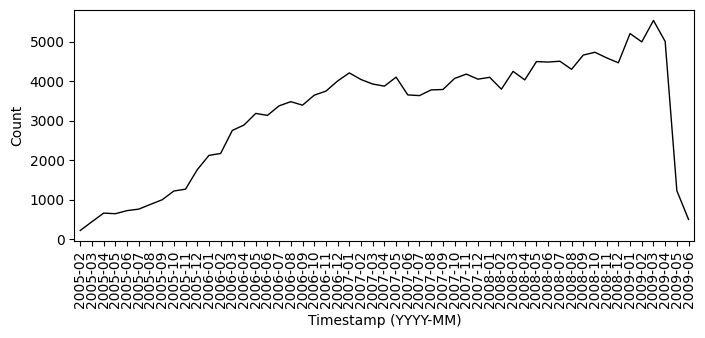

In [11]:
l_dates, l_count = np.unique(l_year_month, return_counts=True)

fig, axs = plt.subplots(figsize=(8,3), facecolor='w', ncols=1, nrows=1)
axs.plot(l_dates, l_count, color='k', lw=1)
axs.set_xlabel("Timestamp (YYYY-MM)")
axs.set_ylabel("Count")
axs.set_xticks(l_dates)
_ = axs.set_xticklabels(l_dates, rotation=90)
axs.set_xlim([-0.5, len(l_dates)-0.5])

---

### 1.3.2. Part 2: Creation of one single network


Definition of network of artists based on user's preferences. To this purpose, select data for only one month. Then, model the solution using a binary graph.


#### 1.3.2.1. Timestamp selection

Select only one month (e.g, Jan. 2007):

In [12]:
bool_mask = (l_year_month=='2007-01')
np.sum(bool_mask)

4215

Get the amount of users and artists that are part of the records for the month you selected. This will be used to create the matrix of nodes/vertices and edges (i.e. $V \times E$).

In [13]:
print("# users", np.unique(df_timestamp['userid'][bool_mask]).shape[0])

# users 457


In [14]:
print("# artists", np.unique(df_timestamp['artist-name'][bool_mask]).shape[0])

# artists 2081


In [15]:
print("# artists", np.unique(df_timestamp['musicbrainz-artist-id'][bool_mask]).shape[0])

# artists 2082


#### 1.3.2.2. Definition of matrix $ V \times U$

Create a matrix of vertices and edges (i.e. $V \times U$) such that it stores the set of artists ($V$) that each user ($U$) listened to. 

Make sure this matrix contains only 0's and 1's as values.

In [16]:
list_of_users = np.unique(df_timestamp['userid'][bool_mask])
print(list_of_users[:5])

['user_000001' 'user_000002' 'user_000003' 'user_000005' 'user_000006']


In [17]:
list_of_artists = np.unique(df_timestamp['musicbrainz-artist-id'][bool_mask])
print(list_of_artists[:10])

['000fc734-b7e1-4a01-92d1-f544261b43f5'
 '001ce2d7-c045-4343-b703-a4fc7dcee0a6'
 '0039c7ae-e1a7-4a7d-9b49-0cbc716821a6'
 '00467da8-2a92-498f-8b10-a80889bcded7'
 '004e5eed-e267-46ea-b504-54526f1f377d'
 '00565b31-14a3-4913-bd22-385eb40dd13c'
 '0065f4cc-cf21-43c2-ad52-92716a579547'
 '006f0783-c5a0-458b-a9da-f8551f7ebe77'
 '00a9f935-ba93-4fc8-a33a-993abe9c936b'
 '00b0a363-2fbc-4af7-b67d-70cf035829e7']


In [18]:
V = list_of_artists.shape[0]
U = list_of_users.shape[0]

print("V = %i; U = %i" % (V, U))

V = 2082; U = 457


Populate matrix $V \times U$ (i.e. `mat_VU`)

In [19]:
mat_UV = np.zeros(shape=(U,V))
for i in range(U):
  mask_i    = df_timestamp['userid'][bool_mask] == list_of_users[i]
  artists_i = df_timestamp['musicbrainz-artist-id'][bool_mask][mask_i].to_numpy()
  for artist in artists_i:
    index = np.where(list_of_artists == artist)[0]
    if (len(index) > 0):
      mat_UV[i,index] = 1

In [20]:
mat_UV.shape, print(np.unique(mat_UV, return_counts=True))

(array([0., 1.]), array([948028,   3446]))


((457, 2082), None)

Check your artists-users matrix by plotting it! 

You can use `plt.imshow(mat_UV, cmap='Greys_r')` if you want.

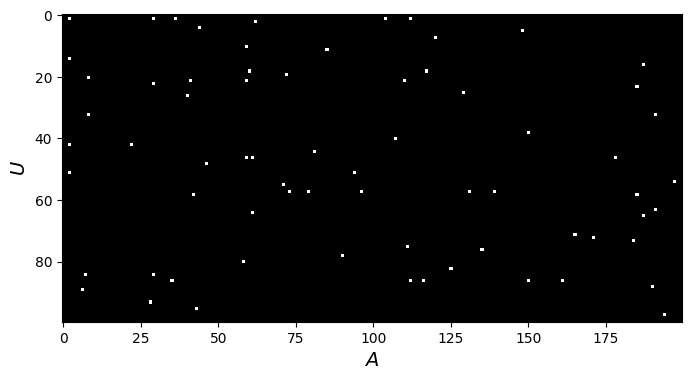

In [21]:
# this will plot only a subset of users and artists:
plt.figure(figsize=(8,4), facecolor='w')
plt.imshow(mat_UV[:,:200][:100], cmap='Greys_r', aspect='auto')
plt.xlabel("$A$", fontsize=14); 
plt.ylabel("$U$", fontsize=14); 

#### 1.3.2.3. Binary graph's adjacency matrix

We can define a routine to convert our artist-users matrix into a binary adjacency matrix $A$.

In order to do so, we might check whether two artists $v_i$ and $v_j$ were listened to by at least one user.

Make sure that the adjacency matrix contains only 0's and 1's! Also, consider that our binary matrix represents an undirected graph. Thus, $A$ is symmetric (and you can reduce the computations to $\frac{V \cdot (V-1)}{2}$ operations! Still $\mathcal{O}(V^2)$ tho 😞)

In [22]:
print(mat_UV[0, :])
print(mat_UV[1, :])

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 1. 0.]


In [23]:
# artists are connected by users 
A = np.zeros(shape=(V,V))
for i in range(V):
  for j in range(i+1, V):
    num_coincidences = np.sum(mat_UV[:,i] * mat_UV[:,j])
    if (num_coincidences > 0): 
      A[i,j] = 1
      A[j,i] = A[i,j]

In [24]:
np.unique(A, return_counts=True)

(array([0., 1.]), array([4285534,   49190]))

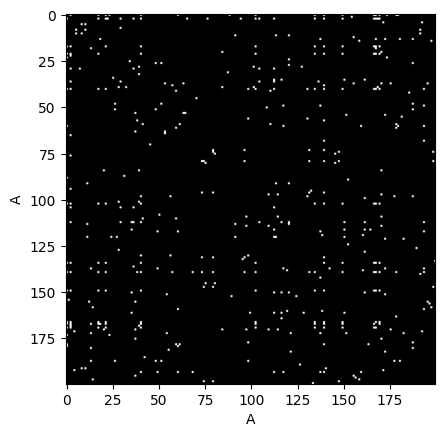

In [25]:
plt.imshow(A[:,:200][:200], cmap='Greys_r')
plt.xlabel("A"); plt.ylabel("A"); 

#### 1.3.2.4. Graph Visualization

Now, let's create a graph that contains the information have in our adjacency matrix $A$.

Using Networkx, we can create a network using the adjacency matrix as input. For example, to create a graph as `G_bin`, we do:

In [26]:
G_bin = nx.Graph(A)

We can use a circular layout as first visualization of our network:

/Users/arvid/opt/anaconda3/envs/elmed219/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


(-1.209999995175484,
 1.2099999995415618,
 -1.2099986291505456,
 1.2099986249449395)

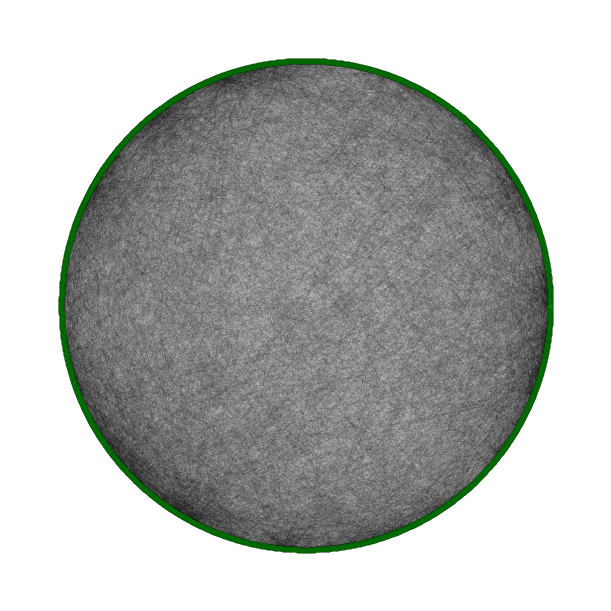

In [27]:
pos = nx.layout.circular_layout(G_bin) 
fig, axs = plt.subplots(figsize=(6,6), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(G_bin, pos, linewidths=0.1, node_color='green', edgecolors='k', ax=axs, cmap='Spectral_r', node_size=15)
nx.draw_networkx_edges(G_bin, pos, width=0.01, ax=axs)
axs.axis('off')

To many connections? let's try with the Spring layout:

In [28]:
pos = nx.layout.circular_layout(G_bin)
pos = nx.spring_layout(G_bin, pos=pos, k=0.7, iterations=100, seed=0)

/Users/arvid/opt/anaconda3/envs/elmed219/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


(-1.1260253620147704,
 1.1497337055206298,
 -1.1464921137690545,
 1.1333319446444512)

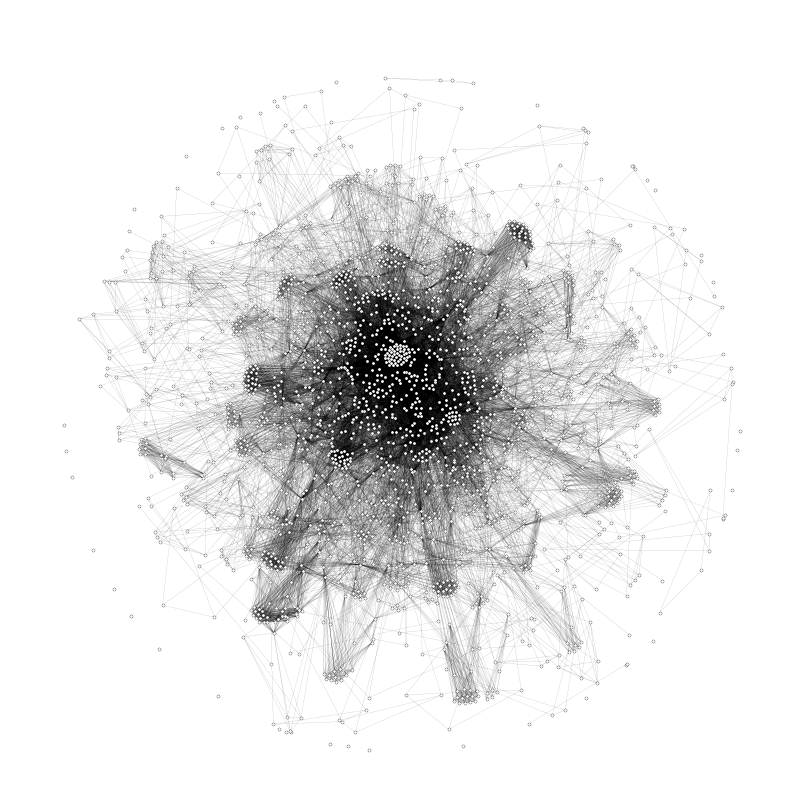

In [29]:
fig, axs = plt.subplots(figsize=(8,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(G_bin, pos, linewidths=0.2, node_color='white', edgecolors='black', ax=axs, cmap='Spectral_r', node_size=5)
nx.draw_networkx_edges(G_bin, pos, edge_color='black', width=0.05, ax=axs)
axs.axis('off')

* What can we observe already? Is it a full graph? 

#### 1.3.2.5. Visualization of the largest (main) component

Some networks may be not fully-connected. In this sub-section we will focus our analyses only in the largest component of our graph.

In order to do so, we need to detect every connected components as sub-graphs:

In [30]:
S_bin = [G_bin.subgraph(c).copy() for c in nx.connected_components(G_bin)]

In [31]:
print("Number of nodes per component:")
np.array([ len(S_bin[i]) for i in range(len(S_bin))])

Number of nodes per component:


array([1960,    7,    3,    7,    3,    2,    5,    4,    5,    2,    4,
          1,    1,    3,    4,    1,    3,    7,    1,    5,    1,    1,
          3,    4,    4,    1,    3,    1,    1,    1,    1,    1,    1,
          4,    1,    2,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    2,    1,    1,    1,
          1,    1,    1,    1])

In [32]:
import numpy as np

In [33]:
list_of_comp = np.array([1960,    7,    3,    7,    3,    2,    5,    4,    5,    2,    4,
          1,    1,    3,    4,    1,    3,    7,    1,    5,    1,    1,
          3,    4,    4,    1,    3,    1,    1,    1,    1,    1,    1,
          4,    1,    2,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    2,    1,    1,    1,
          1,    1,    1,    1])

In [34]:
list_of_comp

array([1960,    7,    3,    7,    3,    2,    5,    4,    5,    2,    4,
          1,    1,    3,    4,    1,    3,    7,    1,    5,    1,    1,
          3,    4,    4,    1,    3,    1,    1,    1,    1,    1,    1,
          4,    1,    2,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    2,    1,    1,    1,
          1,    1,    1,    1])

In [35]:
np.argmax(list_of_comp)

0

Let's visualize the largest components using circular and spring layouts:

In [36]:
# computing layouts
pos = nx.layout.circular_layout(S_bin[0])
pos = nx.spring_layout(S_bin[0], pos=pos, k=0.8, iterations=100, seed=0)

(-1.1240427646040918,
 1.1918712410330774,
 -1.203348879814148,
 1.1400048780441285)

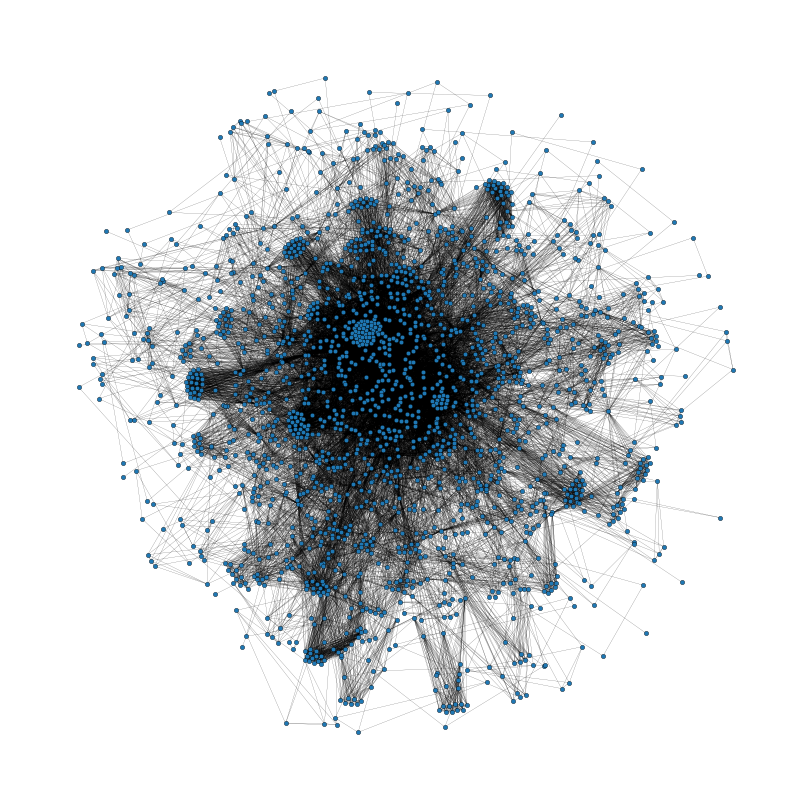

In [37]:
fig, axs = plt.subplots(figsize=(8,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(S_bin[0], pos, linewidths=0.25, edgecolors='k', ax=axs, cmap='Spectral_r', node_size=10)
nx.draw_networkx_edges(S_bin[0], pos, width=0.1, ax=axs)
axs.axis('off')

**Note:** We are considering one month and the connection only needs one shared artist. Shall we include a higher threshold to connect two users?

#### 1.3.2.6. Topology analysis of the largest component

How is the structure of our largest sub-graph? In this part, we need to compute some topology measures. Specifically, we will compute:
+ the network size, 
+ number of links, 
+ average degree, 
+ density, 
+ average clustering coefficient, 
+ average number of triangles, and 
+ average path length.

In [38]:
def get_topology_values(G):
  # input:
  # G: Networkx Graph
  # out:
  # dict (key: metric name, value: metric value)

  d_topology_vals = {
      "network_size" : G.number_of_nodes(),
      "number_of_links" : G.number_of_edges(),
      "avg_degree" : np.mean(list(dict(G.degree()).values())),
      "density" : nx.density(G),
      "accumulated_degeree" : np.sum(list(dict(G.degree()).values())),
      "avg_clustering_coef" : nx.average_clustering(G),
      "avg_triangles" : np.mean(list(nx.triangles(G).values())),
      "avg_path_length" : nx.average_shortest_path_length(G),
  }

  return d_topology_vals

In [39]:
sorted_index = np.argsort([ len(S_bin[i]) for i in range(len(S_bin))])[::-1]

In [40]:
np.array([ len(S_bin[i]) for i in range(len(S_bin))])[sorted_index]

array([1960,    7,    7,    7,    5,    5,    5,    4,    4,    4,    4,
          4,    4,    3,    3,    3,    3,    3,    3,    2,    2,    2,
          2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1])

In [41]:
topology_comp_1 = get_topology_values(S_bin[sorted_index[0]])
topology_comp_2 = get_topology_values(S_bin[sorted_index[1]])

In [42]:
topology_comp_1

{'network_size': 1960,
 'number_of_links': 24447,
 'avg_degree': 24.945918367346938,
 'density': 0.012734006313091852,
 'accumulated_degeree': 48894,
 'avg_clustering_coef': 0.8531065303175233,
 'avg_triangles': 367.5887755102041,
 'avg_path_length': 3.025282057692909}

In [43]:
topology_comp_2

{'network_size': 7,
 'number_of_links': 21,
 'avg_degree': 6.0,
 'density': 1.0,
 'accumulated_degeree': 42,
 'avg_clustering_coef': 1.0,
 'avg_triangles': 15.0,
 'avg_path_length': 1.0}

In [44]:
pd.DataFrame([topology_comp_1, topology_comp_2], index=["S_0", "S_1"]).T

S_0   S_1
network_size          1960.000000   7.0
number_of_links      24447.000000  21.0
avg_degree              24.945918   6.0
density                  0.012734   1.0
accumulated_degeree  48894.000000  42.0
avg_clustering_coef      0.853107   1.0
avg_triangles          367.588776  15.0
avg_path_length          3.025282   1.0

In [45]:
list_of_artists

array(['000fc734-b7e1-4a01-92d1-f544261b43f5',
       '001ce2d7-c045-4343-b703-a4fc7dcee0a6',
       '0039c7ae-e1a7-4a7d-9b49-0cbc716821a6', ...,
       'ffe02aed-ef7e-4736-a186-c2f1dd55ce8d',
       'ffe16bba-4d84-409b-8f22-5242c60b930f',
       'ffe9ec08-6b6b-4993-9394-e280b429dbfd'], dtype=object)

#### 1.3.2.7. Centrality analysis of the largest connected component

In this case, let's analyse the centrality of each node from only the largest connected component. We will use four centrality measures:
1. Degree centrality (`nx.degree_centrality()`)
2. Betweenness centrality (`nx.betweenness_centrality()`)
3. Closeness centrality (`nx.closeness_centrality()`)
4. Eigen-vector centrality (`nx.eigenvector_centrality()`)

Use the attribute `node_color` of  `nx.draw_networkx_nodes` to color each node based on its centrality value!

In [46]:
degree_centrality = np.array(list(nx.degree_centrality(S_bin[0]).values()))
degree_centrality[:10]

array([0.07554875, 0.0086779 , 0.09749872, 0.00204186, 0.00408372,
       0.00510465, 0.00204186, 0.00255232, 0.02348137, 0.00153139])

In [47]:
# computing layouts
pos = nx.layout.circular_layout(S_bin[0])
pos = nx.spring_layout(S_bin[0], pos=pos, k=0.9, iterations=100, seed=0)

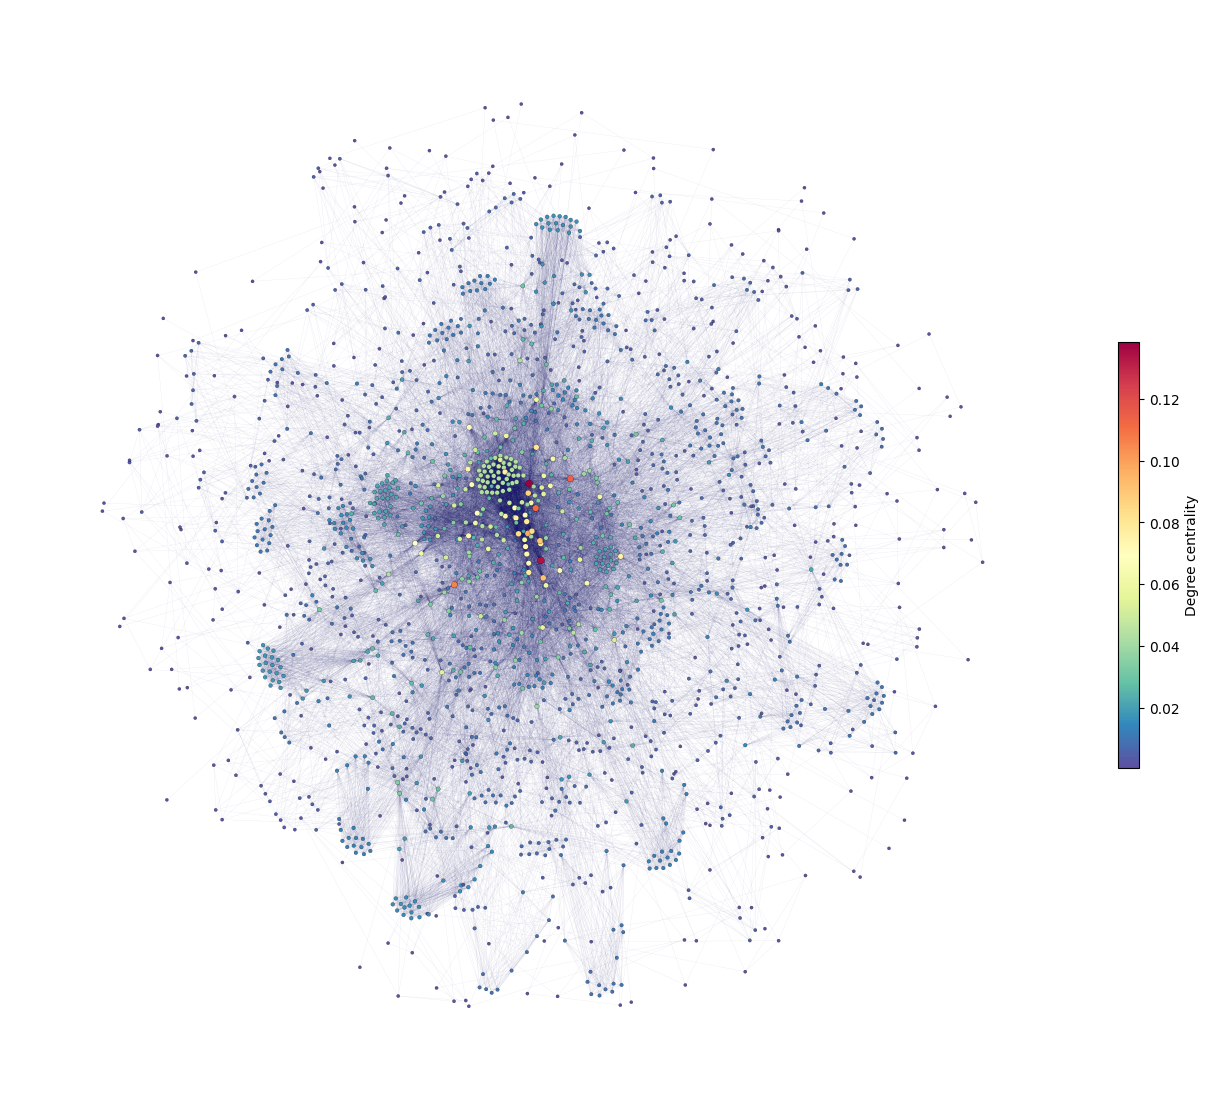

In [48]:
node_color = degree_centrality 
fig, axs = plt.subplots(figsize=(12,11), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(S_bin[0], pos, linewidths=0.15, node_color=node_color, edgecolors='k', ax=axs, cmap='Spectral_r', node_size=5.+(150*node_color))
nx.draw_networkx_edges(S_bin[0], pos, edge_color='midnightblue', alpha=0.1, width=0.2, ax=axs)
axs.axis('off')
cbar=plt.colorbar(sc, ax=axs,fraction=0.02, pad=0.04)
cbar.set_label("Degree centrality")

In [49]:
closeness_centrality   = np.array(list(nx.closeness_centrality(S_bin[0]).values()))
betweenness_centrality = np.array(list(nx.betweenness_centrality(S_bin[0]).values()))
eigenvector_centrality = np.array(list(nx.eigenvector_centrality(S_bin[0]).values()))

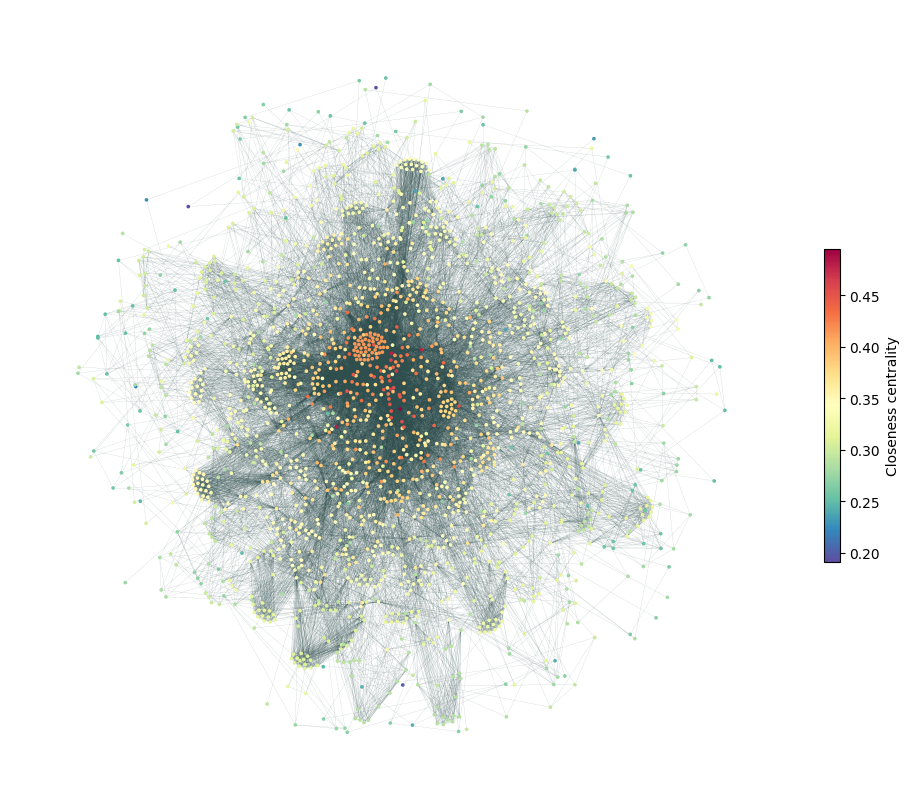

In [50]:
fig, axs = plt.subplots(figsize=(9,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(S_bin[0], pos, linewidths=0, node_color=closeness_centrality, edgecolors='green', ax=axs, cmap='Spectral_r', node_size=7)
nx.draw_networkx_edges(S_bin[0], pos, edge_color='darkslategray', width=0.05, ax=axs)
axs.axis('off')
cbar=plt.colorbar(sc, ax=axs,fraction=0.02, pad=0.04)
cbar.set_label("Closeness centrality")

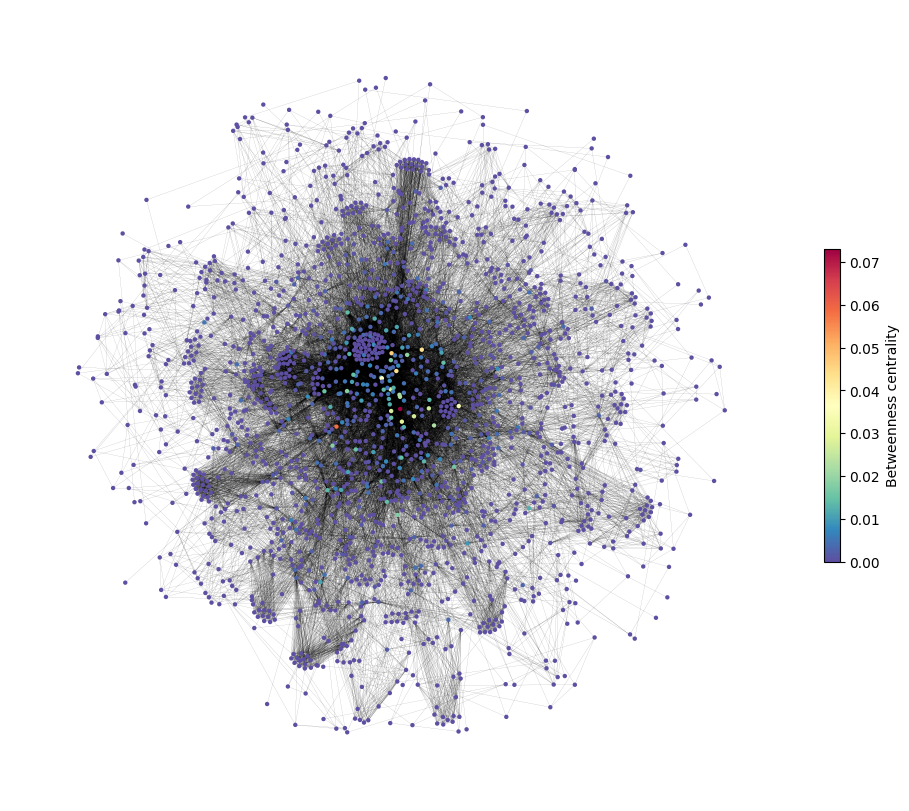

In [51]:
fig, axs = plt.subplots(figsize=(9,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(S_bin[0], pos, linewidths=0, node_color=betweenness_centrality, edgecolors='k', ax=axs, cmap='Spectral_r', node_size=10)
nx.draw_networkx_edges(S_bin[0], pos, edge_color='k', width=0.05, ax=axs)
axs.axis('off')
cbar=plt.colorbar(sc, ax=axs,fraction=0.02, pad=0.04)
cbar.set_label("Betweenness centrality")

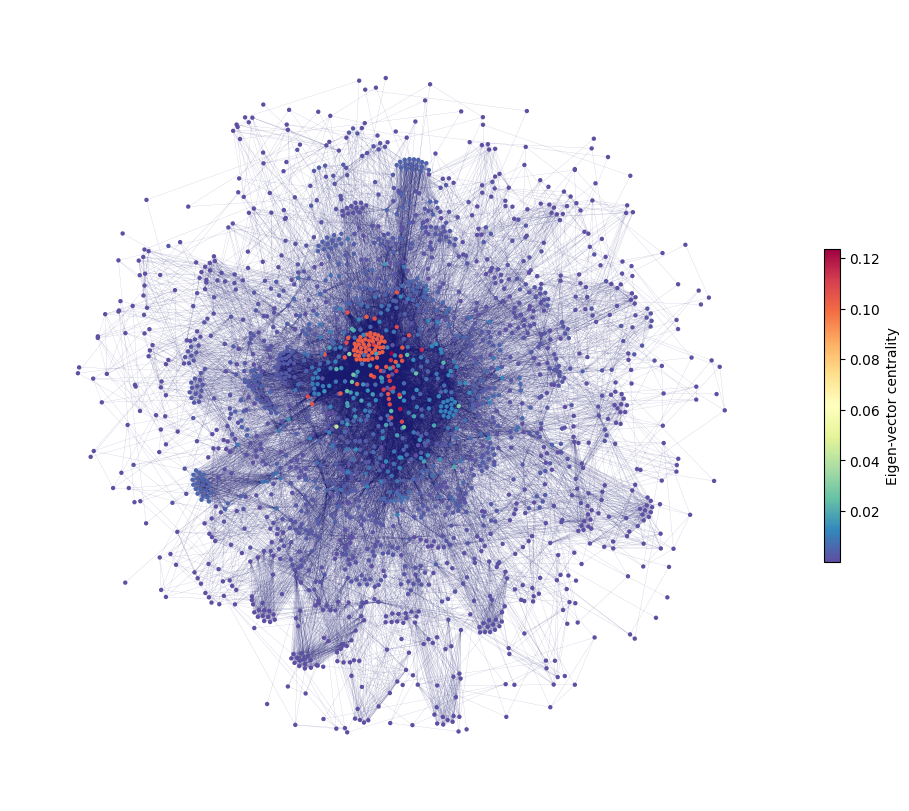

In [52]:
fig, axs = plt.subplots(figsize=(9,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(S_bin[0], pos, linewidths=0, node_color=eigenvector_centrality, edgecolors='k', ax=axs, cmap='Spectral_r', node_size=10)
nx.draw_networkx_edges(S_bin[0], pos, edge_color='midnightblue', width=0.05, ax=axs)
axs.axis('off')
cbar=plt.colorbar(sc, ax=axs,fraction=0.02, pad=0.04)
cbar.set_label("Eigen-vector centrality")

#### 1.3.2.8. Comparison of centrality distributions

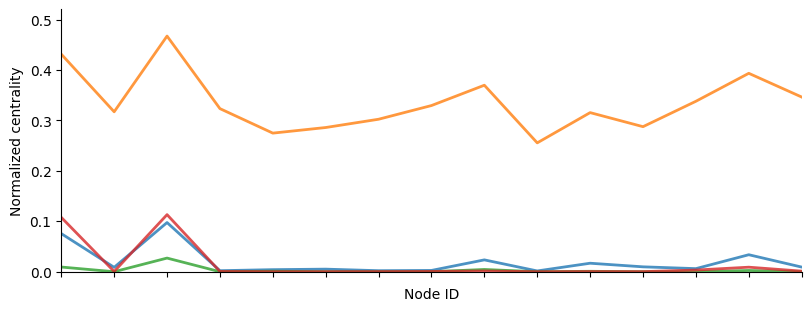

In [53]:
alpha = 0.8; lw=2
fig, axs = plt.subplots(figsize=(8, 3), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
axs.plot(degree_centrality     , lw=lw, alpha=alpha, label='Degree centrality')
axs.plot(closeness_centrality  , lw=lw, alpha=alpha, label='Closeness centrality')
axs.plot(betweenness_centrality, lw=lw, alpha=alpha, label='Betweenness centrality')
axs.plot(eigenvector_centrality, lw=lw, alpha=alpha, label='Eigenvector centrality')
axs.set_xlim([0,14]); axs.set_ylim(bottom=0)
axs.set_xticks(range(15)); axs.set_xticklabels([])
axs.set_ylabel("Normalized centrality")
axs.set_xlabel("Node ID")
axs.spines[['right', 'top']].set_visible(False)

In [54]:
scaled_degree_centrality      = (degree_centrality - np.min(degree_centrality))/(np.max(degree_centrality) - np.min(degree_centrality))
scaled_closeness_centrality   = (closeness_centrality - np.min(closeness_centrality))/(np.max(closeness_centrality) - np.min(closeness_centrality))
scaled_betweenness_centrality = (betweenness_centrality - np.min(betweenness_centrality))/(np.max(betweenness_centrality) - np.min(betweenness_centrality))
scaled_eigenvector_centrality = (eigenvector_centrality - np.min(eigenvector_centrality))/(np.max(eigenvector_centrality) - np.min(eigenvector_centrality))


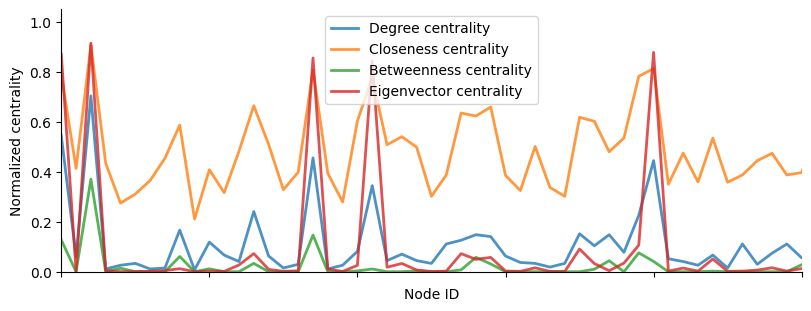

In [55]:
alpha = 0.8; lw=2
fig, axs = plt.subplots(figsize=(8, 3), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
axs.plot(scaled_degree_centrality     , lw=lw, alpha=alpha, label='Degree centrality')
axs.plot(scaled_closeness_centrality  , lw=lw, alpha=alpha, label='Closeness centrality')
axs.plot(scaled_betweenness_centrality, lw=lw, alpha=alpha, label='Betweenness centrality')
axs.plot(scaled_eigenvector_centrality, lw=lw, alpha=alpha, label='Eigenvector centrality')
axs.set_xlim([0,50]); axs.set_ylim(bottom=0)
axs.set_xticklabels([])
axs.set_ylabel("Normalized centrality")
axs.set_xlabel("Node ID")
axs.spines[['right', 'top']].set_visible(False)
axs.legend()

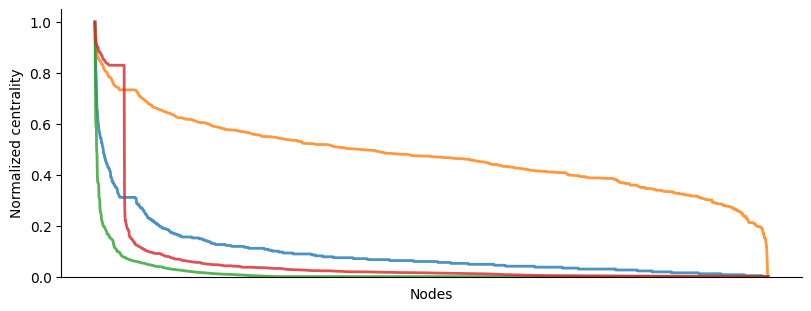

In [56]:
alpha = 0.8; lw=2
fig, axs = plt.subplots(figsize=(8, 3), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
axs.plot(np.sort(scaled_degree_centrality)[::-1]     , lw=lw, alpha=alpha, label='Degree centrality')
axs.plot(np.sort(scaled_closeness_centrality)[::-1]  , lw=lw, alpha=alpha, label='Closeness centrality')
axs.plot(np.sort(scaled_betweenness_centrality)[::-1], lw=lw, alpha=alpha, label='Betweenness centrality')
axs.plot(np.sort(scaled_eigenvector_centrality)[::-1], lw=lw, alpha=alpha, label='Eigenvector centrality')
axs.set_ylim(bottom=0)
axs.set_xticks([])
axs.set_ylabel("Normalized centrality")
axs.set_xlabel("Nodes")
axs.spines[['right', 'top']].set_visible(False)

#### 1.3.2.9. Questions

1. Which are the set of artists that connect the largest amount of users?
2. Which are the sets of artitsts that connect the top 10 artists more importants for connecting users? How to interpret each centrality measure in this case?

In [57]:
list_of_artist_names = df_timestamp['artist-name'][bool_mask].to_numpy()
list_of_artist_names

array(['4Hero', 'Something Corporate', 'Hot Hot Heat', ...,
       "Margot & The Nuclear So And So'S", 'Mogwai', 'Liars'],
      dtype=object)

In [58]:
print("Importance based on degree centrality")
top_artists_degree = list_of_artist_names[np.argsort(degree_centrality)[::-1][:20]]
top_artists_degree

Importance based on degree centrality


array(['Limbonic Art', 'Sun Kil Moon', 'The Doors', 'Smoke Or Fire',
       'Stan Getz', 'Hot Hot Heat', 'Misfits', 'Belle And Sebastian',
       'Britney Spears', 'Jem', 'Therion', 'Nick Drake',
       'John Frusciante', 'Yeah Yeah Yeahs', 'Moonsorrow', 'Ok Go',
       'Gossip', 'Soundgarden', '4Hero', 'Viikate'], dtype=object)

In [59]:
print("Importance based on betweenness centrality")
top_artists_betweenness = list_of_artist_names[np.argsort(betweenness_centrality)[::-1][:20]]
top_artists_betweenness

Importance based on betweenness centrality


array(['Sun Kil Moon', 'Stan Getz', 'Limbonic Art', 'Smoke Or Fire',
       'The Doors', 'Gossip', 'Soundgarden', 'Misfits', 'Hot Hot Heat',
       'Los Planetas', 'Afi', 'Rage Against The Machine',
       'George Harrison', 'Yeah Yeah Yeahs', 'Belle And Sebastian',
       'The Germs', 'R.E.M.', 'Viikate', 'Architecture In Helsinki',
       'Britney Spears'], dtype=object)

In [60]:
print("Importance based on closeness centrality")
top_artists_closeness = list_of_artist_names[np.argsort(closeness_centrality)[::-1][:20]]
top_artists_closeness

Importance based on closeness centrality


array(['Sun Kil Moon', 'Limbonic Art', 'Stan Getz', 'The Doors',
       'Hot Hot Heat', 'Smoke Or Fire', 'Britney Spears', 'Moonsorrow',
       'Jem', 'Soundgarden', 'Misfits', 'Los Planetas', 'Viikate',
       'Belle And Sebastian', 'Ok Go', 'Kreator', 'John Frusciante',
       'Jimmy Eat World', 'Therion', 'Afi'], dtype=object)

In [61]:
print("Importance based on eigen-vector centrality")
top_artists_eigenvector = list_of_artist_names[np.argsort(eigenvector_centrality)[::-1][:20]]
top_artists_eigenvector

Importance based on eigen-vector centrality


array(['Limbonic Art', 'Sun Kil Moon', 'The Doors', 'Hot Hot Heat',
       'Smoke Or Fire', 'Britney Spears', 'John Frusciante', 'Therion',
       'Ok Go', 'Jem', 'Belle And Sebastian', 'Moonsorrow', 'Of Montreal',
       'Désormais', 'Misfits', 'Nick Drake', 'Kreator', 'And One',
       'Masta Ace', '4Hero'], dtype=object)

Depending on the centrality measure we are using we will get different results. Here, the "importance" of each artists have changed across metrics. Therefore, we need to consider the definition of each measure depending on what we want to measure from the network. Thus, this will change depending on the problem domain.

In [62]:
from functools import reduce

In [63]:
reduce(np.intersect1d, (top_artists_betweenness, top_artists_closeness, top_artists_eigenvector))

array(['Belle And Sebastian', 'Britney Spears', 'Hot Hot Heat',
       'Limbonic Art', 'Misfits', 'Smoke Or Fire', 'Sun Kil Moon',
       'The Doors'], dtype=object)

**Note:** When you scale your data, you are changing the *range* of these values. When you normalize your data, you are changing the *shape of the distribution* of your data.


Good! Now that we have some information about the structure of our network, let's study how this evolves across time (months).

----

### 1.3.3. Part 3: Complex network analysis across months
	

In this section, we want to answer the following questions:
+ Study network of artists interconnected by LastFM user's preferences per month. Is the network of artist constantly changing? What are the features (i.e., topology measures) of the each network? Do these result change if we use weighted graphs instead of binary ones?
+ Which is the most central artist per month? Is it the same one? Is it the same if we use another centrality measure?
+ Which are the most top 3 similar artists of most central one?

Are these artists connected always in the same way? How their relation change across months? Using our LastFM dataset, we can check that by creating networks per month. We can look at the different topology measures and see whether they remain the same or fluctuate.

#### 1.3.3.1. Timestamp selection and filtering

In [64]:
l_year_month = np.array([ item[:7] for item in df_timestamp['timestamp'].to_numpy()])

In [65]:
l_unique_year_month = np.unique(l_year_month)
l_unique_year_month

array(['2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07',
       '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01',
       '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07',
       '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01',
       '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07',
       '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01',
       '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07',
       '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01',
       '2009-02', '2009-03', '2009-04', '2009-05', '2009-06'], dtype='<U7')

In [66]:
T = len(l_unique_year_month)
T

53

In [67]:
# list of artists from the whole period of time
list_of_artists = np.unique(df_timestamp['musicbrainz-artist-id'])
print("# artists = %i" % len(list_of_artists))

# artists = 20480


For computational costs, let's consider only the first TOP-50 artists for our analyses (i.e., `max_V = 50`). We will select such the TOP-50 artists that contain the most records in our database:

In [68]:
_, counts = np.unique(df_timestamp['musicbrainz-artist-id'], return_counts=True)

In [69]:
sorted_index = np.argsort(counts)[::-1]

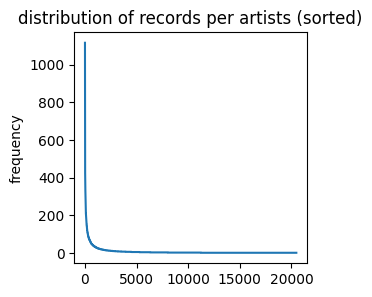

In [70]:
plt.figure(figsize=(3,3), facecolor='w')
plt.plot(counts[ sorted_index ])
plt.ylabel("frequency")
_ = plt.title("distribution of records per artists (sorted)")

In [71]:
list_of_users = np.unique(df_timestamp['userid'])

In [72]:
U = list_of_users.shape[0]
V = list_of_artists.shape[0]

print("U = %i; V = %i" % (U, V))

U = 976; V = 20480


In [73]:
V = 50
list_of_artists = np.unique(df_timestamp['musicbrainz-artist-id'])[sorted_index][:V]

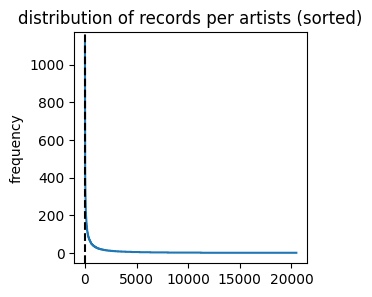

In [74]:
plt.figure(figsize=(3,3), facecolor='w')
plt.plot(counts[ sorted_index ])
plt.axvline(V, ls='--', color='k')
plt.ylabel("frequency")
_ = plt.title("distribution of records per artists (sorted)")

#### 1.3.3.2 Definition of matrix $V \times U \times T$

In [75]:
%%time
# create a matrix NxM per period t in T
mat_VUT = np.zeros(shape=(U,V,T))
for t in range(T):
  temp_year_month = l_unique_year_month[t]
  bool_mask = (l_year_month==temp_year_month)
  print('processing %s (%i out %i)' % (temp_year_month, t+1, T))
  
  for i in range(U):
    mask_i = df_timestamp['userid'][bool_mask] == list_of_users[i]
    artists_i = df_timestamp['musicbrainz-artist-id'][bool_mask][mask_i].to_numpy()
    for artist in artists_i:
      index = np.where(list_of_artists == artist)[0]
      if (len(index) > 0):
        mat_VUT[i, index, t] += 1

processing 2005-02 (1 out 53)
processing 2005-03 (2 out 53)
processing 2005-04 (3 out 53)
processing 2005-05 (4 out 53)
processing 2005-06 (5 out 53)
processing 2005-07 (6 out 53)
processing 2005-08 (7 out 53)
processing 2005-09 (8 out 53)
processing 2005-10 (9 out 53)
processing 2005-11 (10 out 53)
processing 2005-12 (11 out 53)
processing 2006-01 (12 out 53)
processing 2006-02 (13 out 53)
processing 2006-03 (14 out 53)
processing 2006-04 (15 out 53)
processing 2006-05 (16 out 53)
processing 2006-06 (17 out 53)
processing 2006-07 (18 out 53)
processing 2006-08 (19 out 53)
processing 2006-09 (20 out 53)
processing 2006-10 (21 out 53)
processing 2006-11 (22 out 53)
processing 2006-12 (23 out 53)
processing 2007-01 (24 out 53)
processing 2007-02 (25 out 53)
processing 2007-03 (26 out 53)
processing 2007-04 (27 out 53)
processing 2007-05 (28 out 53)
processing 2007-06 (29 out 53)
processing 2007-07 (30 out 53)
processing 2007-08 (31 out 53)
processing 2007-09 (32 out 53)
processing 2007-1

In [76]:
mat_VUT.shape

(976, 50, 53)

In [77]:
np.array([np.sum(mat_VUT[:,:,t]) for t in range(T)])

array([ 22.,  50.,  72.,  62.,  89.,  88., 121., 125., 175., 178., 256.,
       311., 300., 406., 393., 464., 418., 460., 429., 406., 482., 508.,
       491., 561., 553., 505., 489., 512., 456., 475., 452., 402., 538.,
       515., 538., 513., 519., 560., 464., 614., 548., 527., 476., 579.,
       573., 630., 582., 728., 678., 722., 592., 121.,  55.])

#### 1.3.3.3. Weighted graph's adjacency matrix per month

In [78]:
def create_adjacency_matrices(mat_VUT, T_limit=0):
  # artists are connected by users
  U, V, T = mat_VUT.shape
  if T_limit>0:
    T = T_limit
  A_T = np.zeros(shape=(V,V,T))
  for t in range(T):
    for i in range(V):
      for j in range(i+1, V):
        num_coincidences = np.sum(mat_VUT[:,i,t] * mat_VUT[:,j,t])
        if (num_coincidences > 0): 
          A_T[i,j,t] += num_coincidences #1
          A_T[j,i,t] = A_T[i,j,t]
  return A_T

In [79]:
%%time
A_T = create_adjacency_matrices(mat_VUT, T_limit=T)

CPU times: user 1.11 s, sys: 6.72 ms, total: 1.12 s
Wall time: 1.13 s


In [80]:
A_T.shape

(50, 50, 53)

In [81]:
current_T = A_T.shape[2]

In [82]:
# selecting list of graphs
l_G = [nx.Graph(A_T[:,:,t]) for t in range(current_T)]

#### 1.3.3.4. Graph visualizations

Visualization pf graphs and adjacency matrices across time

In [83]:
pos = nx.layout.circular_layout(l_G[0])
pos = nx.spring_layout(l_G[1], k=0.2, pos=pos, iterations=100, seed=0)
pos = nx.spring_layout(l_G[1], pos=pos, iterations=100, seed=0)

/Users/arvid/opt/anaconda3/envs/elmed219/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


(-1.0783638589190556,
 1.0989697075675742,
 -1.084534605226388,
 1.0964921727110561)

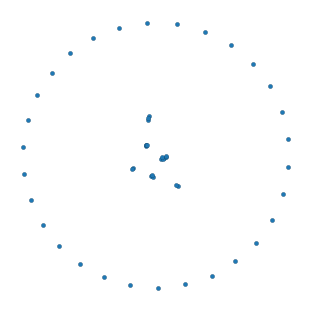

In [84]:
fig, axs = plt.subplots(figsize=(3,3), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(l_G[1], pos, linewidths=0.1, edgecolors='k', ax=axs, cmap='Spectral_r', node_size=10)
nx.draw_networkx_edges(l_G[1], pos, width=0.1, ax=axs)
axs.axis('off')

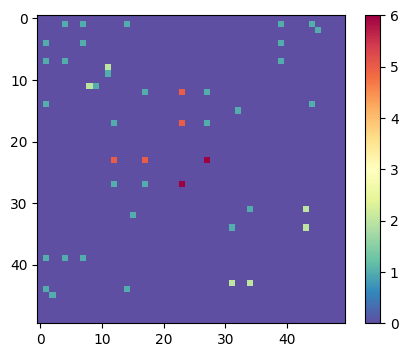

In [85]:
plt.figure(figsize=(5,4), facecolor='w')
plt.imshow(nx.adjacency_matrix(l_G[1]).todense(), cmap='Spectral_r')
plt.colorbar()

In [86]:
plot_T = 5

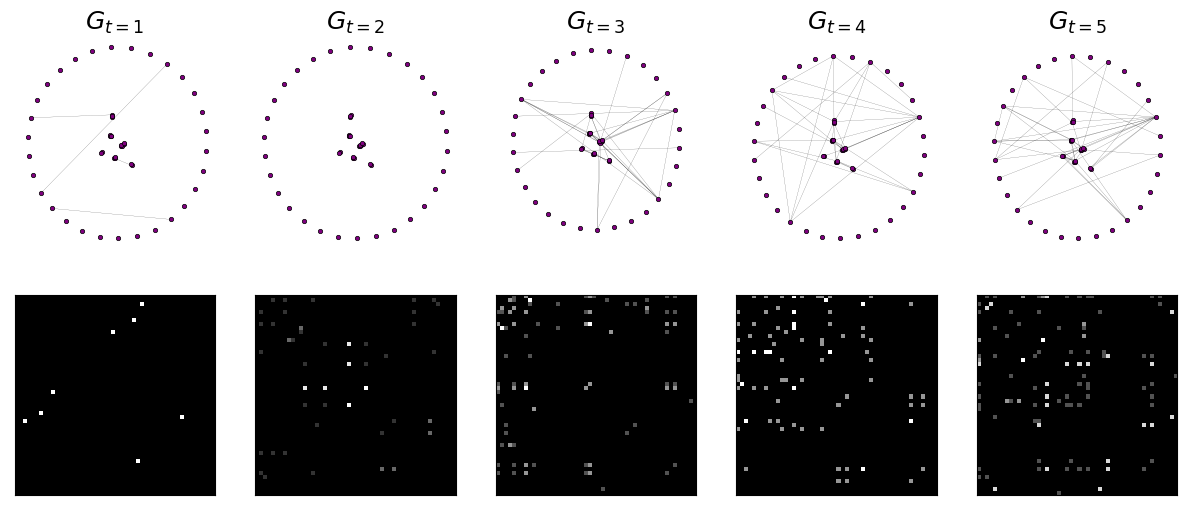

In [87]:
fig, axs = plt.subplots(figsize=(3*plot_T,6), facecolor="w", nrows=2, ncols=plot_T)
for t in range(plot_T):
  # graph visualization
  nx.draw_networkx_nodes(
      l_G[t], pos, node_color='purple', linewidths=0.5, 
      edgecolors='k', ax=axs[0][t], node_size=10)
  nx.draw_networkx_edges(l_G[t], pos, width=0.1, ax=axs[0][t])
  axs[0][t].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
  axs[0][t].set_title("$G_{t=%i}$" % (t+1), fontsize=18)
  
  # adjacency matrix
  axs[1][t].imshow(A_T[:,:,t], cmap="Greys_r")
  axs[1][t].imshow(A_T[:,:,t], cmap="Greys_r")
  axs[1][t].set_xticks([]); axs[1][t].set_yticks([]);

In [88]:
def compute_features_from_graph(G):
  d_features = {
    'mean_degree' : np.mean(list(dict(G.degree()).values())),
    'density' : nx.density(G),
    'num_edges' : G.number_of_edges(),
    'num_connected_components' : nx.number_connected_components(G),
    'mean_clustering_coef' : nx.average_clustering(G),
    'num_triangles' : np.mean(list(dict(nx.triangles(G)).values()))
  }
  return d_features

In [89]:
np.array([np.mean(nx.adjacency_matrix(l_G[t]).todense())/2 for t in range(len(l_G))])

array([0.0016, 0.0152, 0.024 , 0.0192, 0.0316, 0.0708, 0.0824, 0.0736,
       0.0996, 0.1188, 0.1392, 0.1588, 0.1496, 0.2932, 0.1872, 0.238 ,
       0.2236, 0.3648, 0.3192, 0.1988, 0.2732, 0.3864, 0.3036, 0.4164,
       0.3808, 0.3592, 0.2768, 0.2724, 0.2168, 0.1988, 0.1792, 0.1812,
       0.24  , 0.2212, 0.2188, 0.2116, 0.2796, 0.3024, 0.1984, 0.4384,
       0.3356, 0.4004, 0.332 , 0.4652, 0.3192, 0.3888, 0.3056, 0.4632,
       0.3132, 0.352 , 0.3576, 0.05  , 0.028 ])

#### 1.3.3.5. Analysis across time: Changes in networks' topology 

In [90]:
l_features = [compute_features_from_graph(l_G[t]) for t in range(len(l_G))]

In [91]:
df_features = pd.DataFrame(l_features)
df_features

mean_degree   density  num_edges  num_connected_components  \
0          0.16  0.003265          4                        46   
1          0.88  0.017959         22                        36   
2          1.60  0.032653         40                        30   
3          1.60  0.032653         40                        27   
4          2.00  0.040816         50                        24   
5          2.72  0.055510         68                        21   
6          3.60  0.073469         90                        17   
7          2.36  0.048163         59                        20   
8          4.44  0.090612        111                        10   
9          4.40  0.089796        110                        10   
10         5.76  0.117551        144                         4   
11         7.00  0.142857        175                         4   
12         7.76  0.158367        194                         4   
13        10.92  0.222857        273                         3   
14         9.08  0.185306        227                         4   
15         9.68  0.197551        242                         2   
16         9.92  0.202449        248                         3   
17        12.72  0.259592        318                         2   
18        11.24  0.229388        281                         3   
19         9.20  0.187755        230                         2   
20        12.16  0.248163        304                         1   
21        12.56  0.256327        314                         3   
22        10.64  0.217143        266                         2   
23        14.16  0.288980        354                         2   
24        14.92  0.304490        373                         2   
25        10.76  0.219592        269                         1   
26        10.32  0.210612        258                         2   
27         8.48  0.173061        212                         2   
28        10.36  0.211429        259                         2   
29         9.08  0.185306        227                         1   
30         8.80  0.179592        220                         2   
31         9.32  0.190204        233                         2   
32         9.80  0.200000        245                         2   
33        10.32  0.210612        258                         1   
34         9.40  0.191837        235                         1   
35        10.04  0.204898        251                         1   
36         9.92  0.202449        248                         2   
37        11.88  0.242449        297                         1   
38         8.60  0.175510        215                         1   
39        12.72  0.259592        318                         1   
40        12.08  0.246531        302                         1   
41        14.20  0.289796        355                         2   
42        11.28  0.230204        282                         1   
43        14.48  0.295510        362                         1   
44        12.84  0.262041        321                         2   
45        14.00  0.285714        350                         1   
46        11.96  0.244082        299                         1   
47        15.64  0.319184        391                         1   
48        11.92  0.243265        298                         2   
49        14.40  0.293878        360                         1   
50        12.84  0.262041        321                         1   
51         2.52  0.051429         63                        20   
52         1.08  0.022041         27                        35   

    mean_clustering_coef  num_triangles  
0               0.000000           0.00  
1               0.248000           0.60  
2               0.232190           2.46  
3               0.251333           1.56  
4               0.324433           1.98  
5               0.401325           4.86  
6               0.379708           6.60  
7               0.369143           2.76  
8               0.380186           5.40  
9               0.3

#### 1.3.3.6. Visualization of changes of networks structure

/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_20614/1384422455.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(l_unique_year_month, rotation=90)


(-0.5, 52.5)

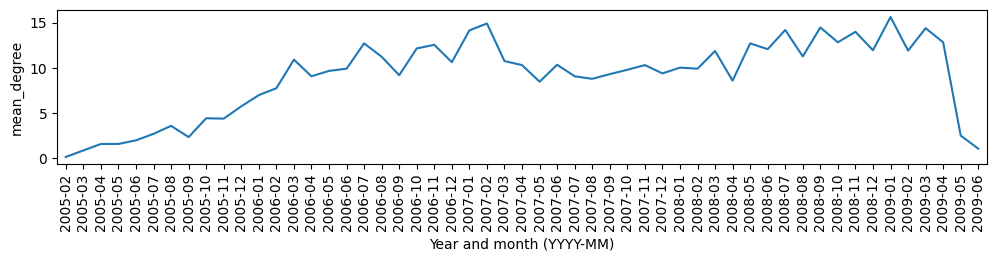

In [92]:
fig, axs = plt.subplots(figsize=(12,2), facecolor='w')
plt.plot(l_unique_year_month, df_features['mean_degree'])
axs.set_xlabel("Year and month (YYYY-MM)")
axs.set_ylabel("mean_degree")
axs.set_xticklabels(l_unique_year_month, rotation=90)
axs.set_xlim([-0.5, len(l_unique_year_month)-0.5])

/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_20614/799856328.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(l_unique_year_month, rotation=90)


(-0.5, 52.5)

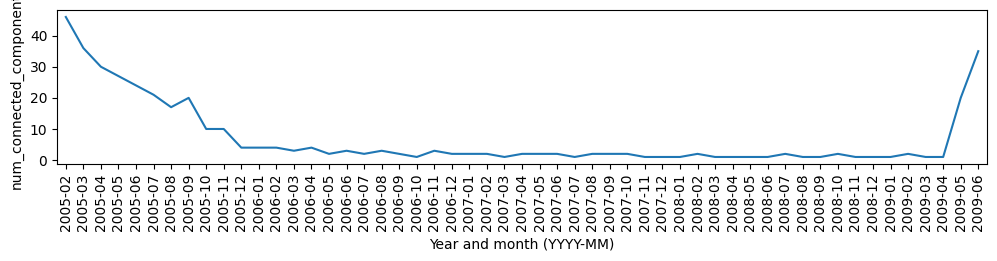

In [93]:
fig, axs = plt.subplots(figsize=(12,2), facecolor='w')
plt.plot(l_unique_year_month, df_features['num_connected_components'])
axs.set_xlabel("Year and month (YYYY-MM)")
axs.set_ylabel("num_connected_components")
axs.set_xticklabels(l_unique_year_month, rotation=90)
axs.set_xlim([-0.5, len(l_unique_year_month)-0.5])

/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_20614/4021170920.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(l_unique_year_month, rotation=90)


(-0.5, 52.5)

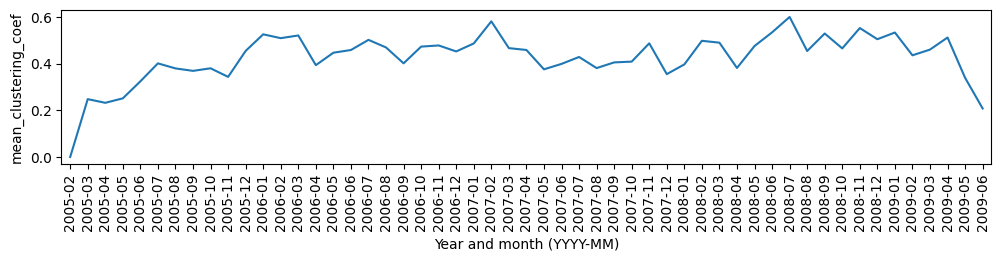

In [94]:
fig, axs = plt.subplots(figsize=(12,2), facecolor='w')
plt.plot(l_unique_year_month, df_features['mean_clustering_coef'])
axs.set_xlabel("Year and month (YYYY-MM)")
axs.set_ylabel("mean_clustering_coef")
axs.set_xticklabels(l_unique_year_month, rotation=90)
axs.set_xlim([-0.5, len(l_unique_year_month)-0.5])

/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_20614/347174644.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(l_unique_year_month, rotation=90)


(-0.5, 52.5)

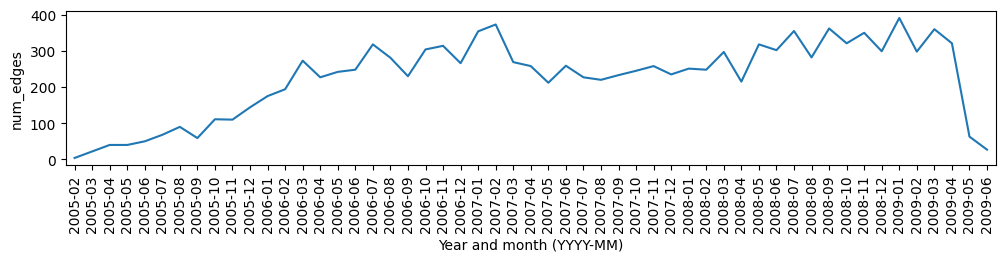

In [95]:
fig, axs = plt.subplots(figsize=(12,2), facecolor='w')
plt.plot(l_unique_year_month, df_features['num_edges'])
axs.set_xlabel("Year and month (YYYY-MM)")
axs.set_ylabel("num_edges")
axs.set_xticklabels(l_unique_year_month, rotation=90)
axs.set_xlim([-0.5, len(l_unique_year_month)-0.5])

#### 1.3.3.7. Centrality analysis across time

In [96]:
l_S_T = []
for t in range(T):
  S_T = [l_G[t].subgraph(c).copy() for c in nx.connected_components(l_G[t])]
  l_S_T.append( S_T )

In [97]:
print("Number of nodes per component:")
for t in range(T):
  print( "Epoch %i" % t, np.array([ len(l_S_T[t][i]) for i in range(len(l_S_T[t]))]) )


Number of nodes per component:
Epoch 0 [1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
Epoch 1 [1 6 2 1 1 1 3 1 4 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1]
Epoch 2 [20  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
Epoch 3 [23  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1]
Epoch 4 [27  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Epoch 5 [ 3 27  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Epoch 6 [31  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Epoch 7 [30  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1]
Epoch 8 [40  1  1  2  1  1  1  1  1  1]
Epoch 9 [41  1  1  1  1  1  1  1  1  1]
Epoch 10 [47  1  1  1]
Epoch 11 [47  1  1  1]
Epoch 12 [46  1  1  2]
Epoch 13 [48  1  1]
Epoch 14 [47  1  1  1]
Epoch 15 [49  1]
Epoch 16 [48  1  1]
Epoch 17 [49  1]
Epoch 18 [48  1  1]
Epoch 19 [49  1]
Epoch 20 [50]
Epoch 21

In [100]:
largest_cc = max(nx.connected_components(l_G[1]), key=len)
len(largest_cc)

6

In [116]:
# node_main_component = np.array([ np.array(list(max(nx.connected_components(l_G[t]), key=len))) for t in range(10,40)])
# --> ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.
# Fix:
node_main_component = [list(max(nx.connected_components(l_G[t]), key=len)) for t in range(10,40)]

In [117]:
np.array(node_main_component[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49])

In [104]:
# nodes in t=10 AND t=20
np.intersect1d(node_main_component[0], node_main_component[10]) 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49])

In [105]:
common_nodes = reduce(np.intersect1d, node_main_component)
common_nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       19, 20, 21, 22, 23, 24, 26, 28, 31, 33, 34, 35, 36, 38, 42, 47])

Let's select such nodes (and their connections) that are common across the dataset from epoch 10 to 40:

In [106]:
l_subgraphs = []
for t in range(10,40):
  l_subgraphs.append( nx.subgraph(l_G[t], common_nodes) )

In [107]:
degree_centrality = np.array(np.array([np.array(list(nx.degree_centrality(l_subgraphs[t]).values())) for t in range(len(l_subgraphs))]))
degree_centrality

array([[0.21875, 0.34375, 0.03125, 0.15625, 0.09375, 0.0625 , 0.125  ,
        0.25   , 0.28125, 0.375  , 0.1875 , 0.15625, 0.21875, 0.03125,
        0.09375, 0.21875, 0.     , 0.0625 , 0.0625 , 0.125  , 0.21875,
        0.3125 , 0.09375, 0.1875 , 0.1875 , 0.0625 , 0.09375, 0.09375,
        0.15625, 0.15625, 0.25   , 0.21875, 0.25   ],
       [0.53125, 0.40625, 0.28125, 0.03125, 0.34375, 0.25   , 0.4375 ,
        0.375  , 0.0625 , 0.34375, 0.125  , 0.15625, 0.15625, 0.3125 ,
        0.03125, 0.1875 , 0.1875 , 0.0625 , 0.0625 , 0.15625, 0.40625,
        0.21875, 0.125  , 0.0625 , 0.21875, 0.125  , 0.15625, 0.125  ,
        0.21875, 0.34375, 0.125  , 0.21875, 0.15625],
       [0.5    , 0.4375 , 0.15625, 0.0625 , 0.28125, 0.34375, 0.375  ,
        0.59375, 0.     , 0.25   , 0.09375, 0.28125, 0.375  , 0.21875,
        0.09375, 0.0625 , 0.25   , 0.25   , 0.15625, 0.28125, 0.15625,
        0.34375, 0.15625, 0.28125, 0.28125, 0.1875 , 0.21875, 0.09375,
        0.09375, 0.3125 , 0.125  , 0.125

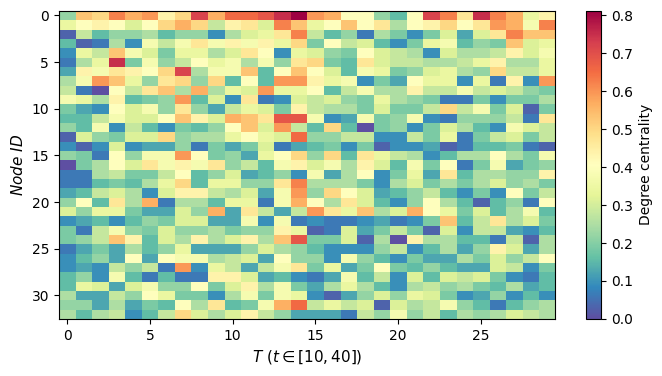

In [108]:
plt.figure(figsize=(8,4), facecolor='w')
plt.imshow(degree_centrality.T, cmap='Spectral_r', aspect='auto')
plt.xlabel("$T\ (t \in [10,40])$", fontsize=11)
plt.ylabel("$Node\ ID$", fontsize=11)
plt.colorbar(label="Degree centrality")

In [109]:
betweenness_centrality = np.array(np.array([np.array(list(nx.betweenness_centrality(l_subgraphs[t]).values())) for t in range(len(l_subgraphs))]))
closeness_centrality   = np.array(np.array([np.array(list(nx.closeness_centrality(l_subgraphs[t]).values())) for t in range(len(l_subgraphs))]))
eigenvector_centrality = np.array(np.array([np.array(list(nx.eigenvector_centrality(l_subgraphs[t]).values())) for t in range(len(l_subgraphs))]))

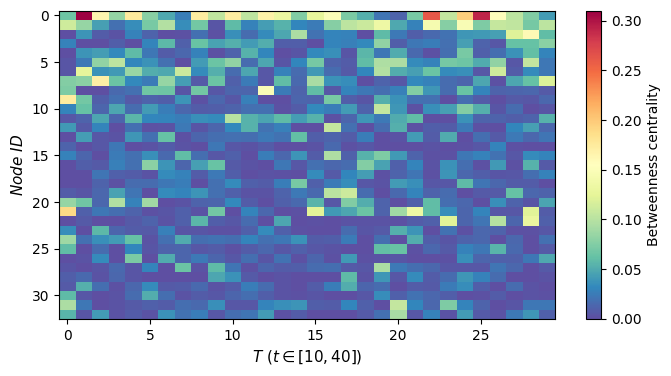

In [110]:
plt.figure(figsize=(8,4), facecolor='w')
plt.imshow(betweenness_centrality.T, cmap='Spectral_r', aspect='auto')
plt.xlabel("$T\ (t \in [10,40])$", fontsize=11)
plt.ylabel("$Node\ ID$", fontsize=11)
plt.colorbar(label="Betweenness centrality")

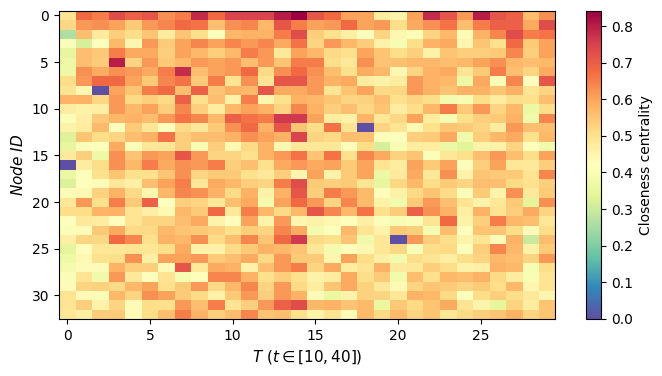

In [111]:
plt.figure(figsize=(8,4), facecolor='w')
plt.imshow(closeness_centrality.T, cmap='Spectral_r', aspect='auto')
plt.xlabel("$T\ (t \in [10,40])$", fontsize=11)
plt.ylabel("$Node\ ID$", fontsize=11)
plt.colorbar(label="Closeness centrality")

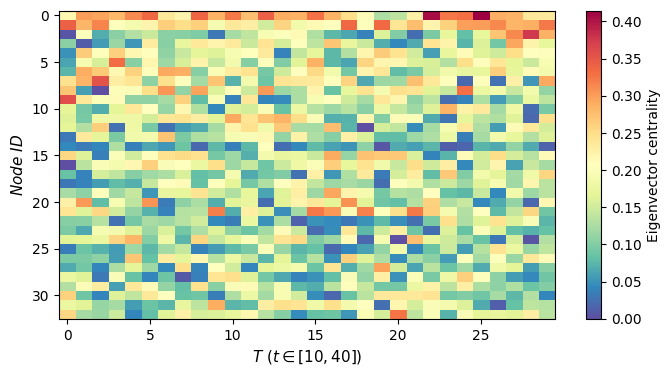

In [112]:
plt.figure(figsize=(8,4), facecolor='w')
plt.imshow(eigenvector_centrality.T, cmap='Spectral_r', aspect='auto')
plt.xlabel("$T\ (t \in [10,40])$", fontsize=11)
plt.ylabel("$Node\ ID$", fontsize=11)
plt.colorbar(label="Eigenvector centrality")

In [113]:
top1_degree_centrality      = np.array([list_of_artist_names[ np.argmax(degree_centrality[t,:]     ) ] for t in range(len(l_subgraphs))])
top1_betweenness_centrality = np.array([list_of_artist_names[ np.argmax(betweenness_centrality[t,:]) ] for t in range(len(l_subgraphs))])
top1_closeness_centrality   = np.array([list_of_artist_names[ np.argmax(closeness_centrality[  t,:]) ] for t in range(len(l_subgraphs))])
top1_eigenvector_centrality = np.array([list_of_artist_names[ np.argmax(eigenvector_centrality[t,:]) ] for t in range(len(l_subgraphs))])

Top influencial bands for users from LastFM comunnity:

In [114]:
pd.DataFrame([
    range(10,40),
    top1_degree_centrality, 
    top1_betweenness_centrality,
    top1_closeness_centrality,
    top1_eigenvector_centrality], 
    index=["timestamp","degree", "betweenness", "closeness", "eigenvector"]
    ).T

timestamp                    degree                     betweenness  \
0         10  The Sunshine Underground                  Regina Spektor   
1         11                     4Hero                           4Hero   
2         12        Panic At The Disco              Panic At The Disco   
3         13  The Sunshine Underground        The Sunshine Underground   
4         14                     4Hero                           4Hero   
5         15                     4Hero                      The Sounds   
6         16               Maxïmo Park             Something Corporate   
7         17                The Zutons                      The Zutons   
8         18                     4Hero                           4Hero   
9         19                     4Hero                           4Hero   
10        20                     4Hero                           4Hero   
11        21                     4Hero                           4Hero   
12        22                     4Hero                           4Hero   
13        23                     4Hero                           4Hero   
14        24                     4Hero                    Hot Hot Heat   
15        25                     4Hero                           4Hero   
16        26                     4Hero                           4Hero   
17        27       Something Corporate                     Imogen Heap   
18        28            Regina Spektor             Something Corporate   
19        29       Something Corporate             Something Corporate   
20        30                      Кино                            Mylo   
21        31            Regina Spektor                  Regina Spektor   
22        32                     4Hero                           4Hero   
23        33                     4Hero  Creedence Clearwater Revisited   
24        34                     4Hero                           4Hero   
25        35                     4Hero                           4Hero   
26        36                     4Hero                           4Hero   
27        37              Hot Hot Heat                    Hot Hot Heat   
28        38              Hot Hot Heat                    Hot Hot Heat   
29        39       Something Corporate              Panic At The Disco   

                   closeness               eigenvector  
0   The Sunshine Underground  The Sunshine Underground  
1                      4Hero                The Sounds  
2         Panic At The Disco        Panic At The Disco  
3   The Sunshine Underground  The Sunshine Underground  
4                      4Hero                     4Hero  
5                      4Hero                     4Hero  
6                Maxïmo Park               Maxïmo Park  
7                 The Zutons                The Zutons  
8                      4Hero                     4Hero  
9                      4Hero            Regina Spektor  
10                     4Hero                     4Hero  
11                     4Hero                     4Hero  
12                     4Hero                     4Hero  
13                     4Hero                     4Hero  
14                     4Hero                     4Hero  
15                     4Hero                     4Hero  
16                     4Hero            Regina Spektor  
17       Something Corporate       Something Corporate  
18            Regina Spektor            Regina Spektor  
19       Something Corporate       Something Corporate  
20                      Кино                      Кино  
21            Regina Spektor            Regina Spektor  
22                     4Hero                     4Hero  
23                     4Hero                     4Hero  
24                     4Hero               Maxïmo Park  
25                     4Hero                     4Hero  
26                     4Hero       Something Corporate  
27              Hot Hot Heat              Hot Hot Heat  
28              Hot Hot Heat              Hot Hot Heat 

---

# References

[1] Benson, A. R., Kumar, R., & Tomkins, A. (2018, February). A discrete choice model for subset selection. In Proceedings of the eleventh ACM international conference on web search and data mining (pp. 37-45).

[2] Celma, O. (2010). Music recommendation and discovery: The long tail, long fail, and long play in the digital music space. Springer Science & Business Media.

[3] Lamere, P. The LastFM ArtistTags2007 Data set, 2008. URL http://musicmachinery.com/2010/11/10/lastfm-artisttags2007.

[4] Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere.  The Million Song Dataset. In Proceedings of the 12th International Society
for Music Information Retrieval Conference (ISMIR 2011), 2011. A [[tutorial](http://millionsongdataset.com/sites/default/files/tutorial1.py.txt)] is available as well.